Based on https://github.com/naokishibuya/car-finding-lane-lines

In [7]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
g_silent = False
g_images_dir = 'more_images'
g_dbg_tags = ['src', 'white_yellow', 'contour']
g_dbg_indices = range(2,4)
g_use_roi = False
g_white_low = [0,200,0]

In [8]:
def show_images_(images, cmap):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def show_images(images, tag, cmap=None):
    if g_dbg_tags is None or tag in g_dbg_tags:
        show_images_([images[x] for x in range(len(images)) if x in g_dbg_indices], cmap)

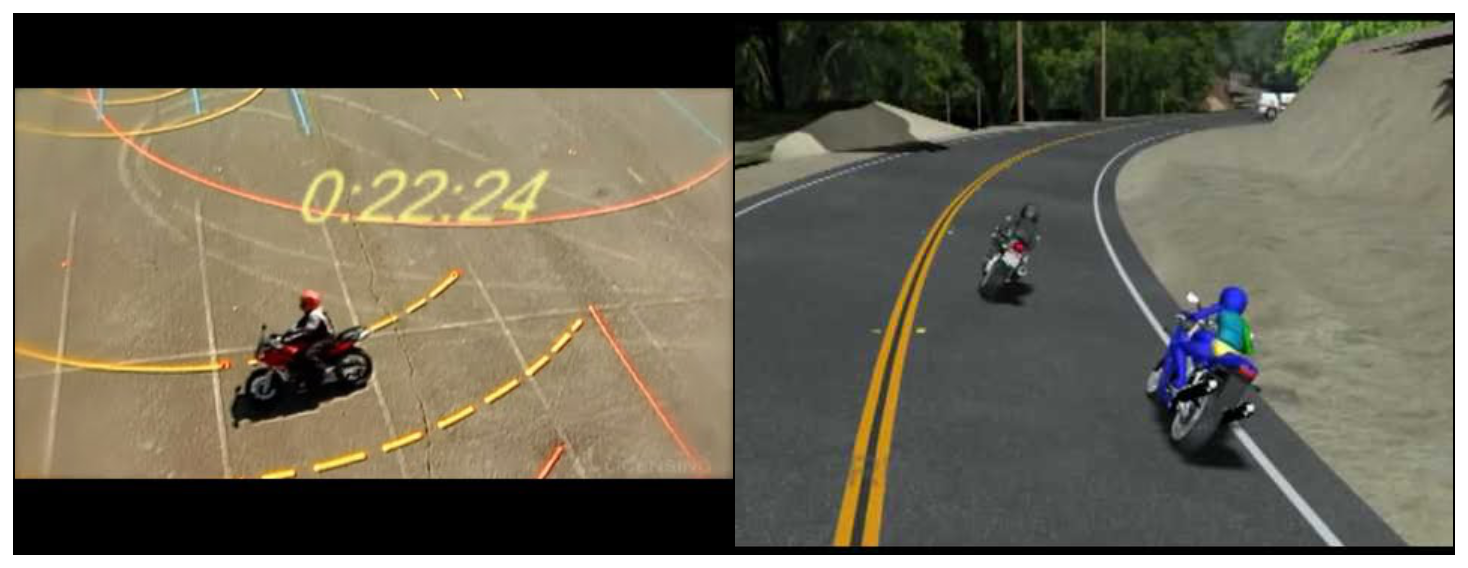

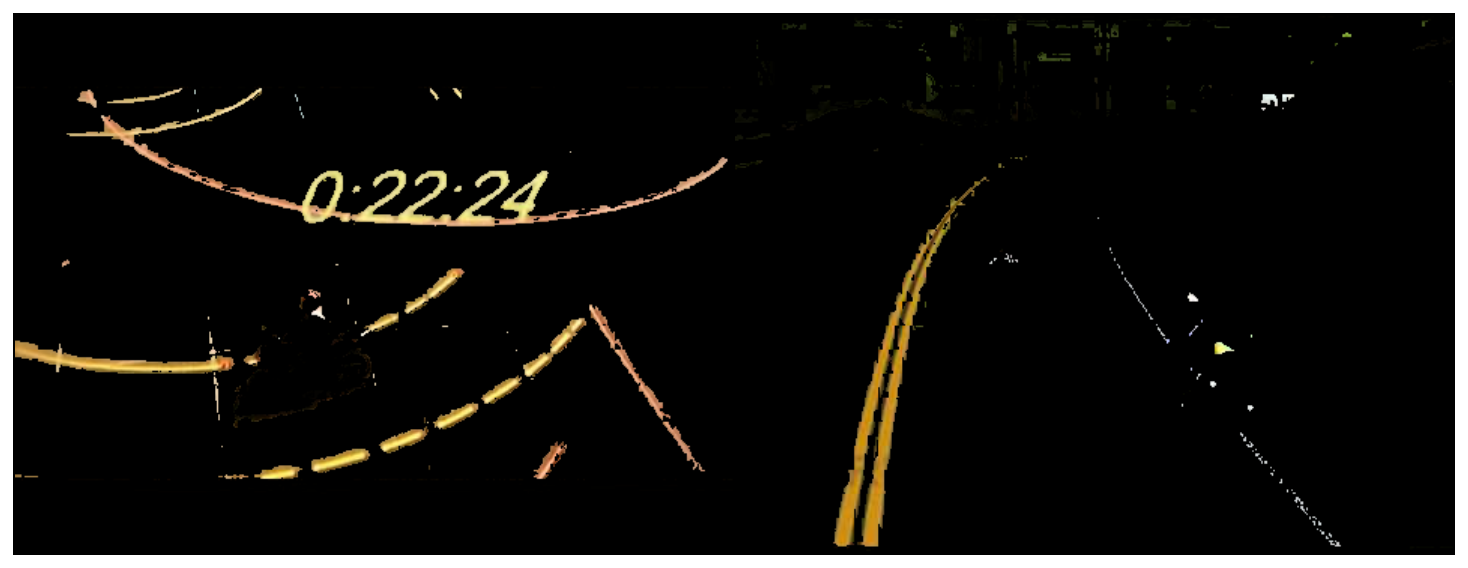

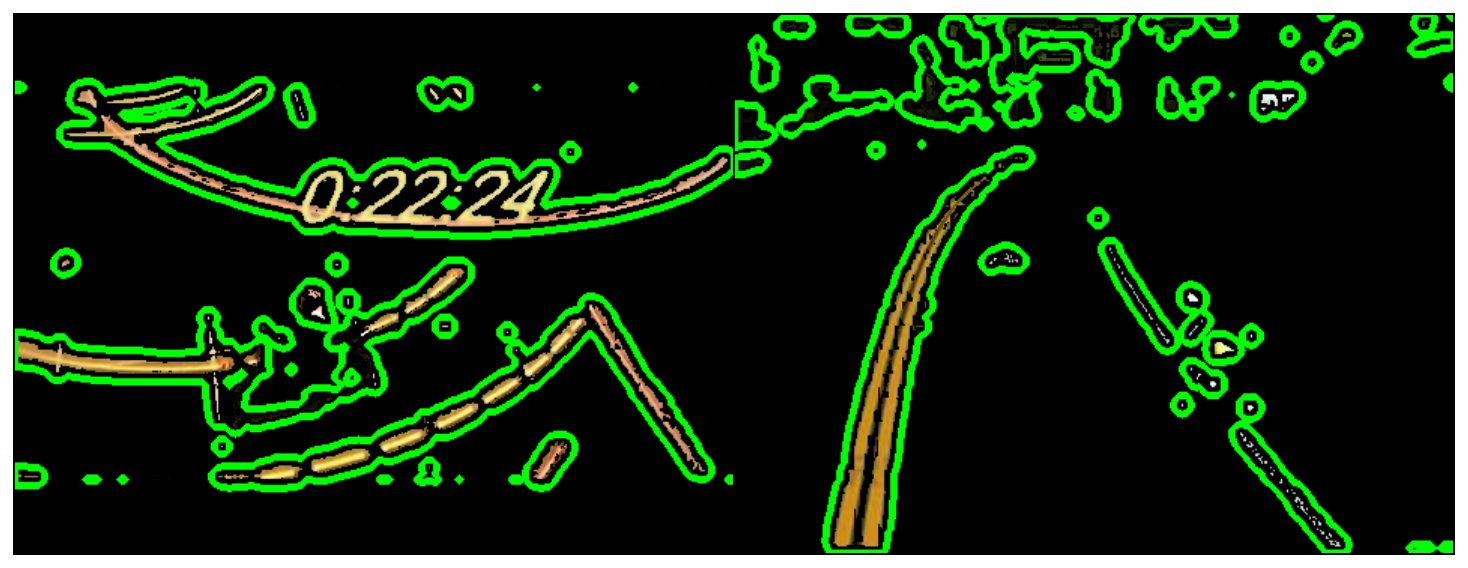

In [9]:
src_images = [plt.imread(path) for path in glob.glob('data/{}/*.jpg'.format(g_images_dir))]
show_images(src_images, 'src')

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
show_images(list(map(convert_hls, src_images)), 'hls')

def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8(g_white_low)
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, src_images))
show_images(white_yellow_images, 'white_yellow')

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))
show_images(gray_images, 'gray')

def apply_smoothing(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images, 'blurred')

if True:
    contour_images = []
    for i, img in enumerate(blurred_images):
        img2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        #print len(contours)
        contour_images.append(cv2.drawContours(white_yellow_images[i], contours, -1, (0,255,0), 3))
    show_images(contour_images, 'contour')
    
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))
show_images(edge_images, 'edge')